In [1]:
# pip install pyproximal

In [2]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jaxopt
import pyproximal
import pylops
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
import multidms

## Load data

In [3]:
func_scores_df_processed = pd.read_csv(
    "input/spike_func_scores.csv").fillna("")#.query("replicate == 1")

func_scores_df_processed

,func_score,aa_substitutions,condition,replicate,n_subs
0,0.4616,N87T L517F T1006A,Delta,1,3
1,1.5096,D80L,Delta,1,1
2,-0.7202,A1026V D1168Y,Delta,1,2
3,1.1890,G75W K1154E,Delta,1,2
4,-1.2116,T307S S803L A893V,Delta,1,3
...,...,...,...,...,...
689428,-3.5000,K182R N405L S408* T941S D1163Y,Omicron_BA2,2,5
689429,-0.7129,P82S S112T D138T K1038N,Omicron_BA2,2,4
689430,-0.8500,L179P A222T G261H N405D,Omicron_BA2,2,4
689431,-2.3933,S27F G413E,Omicron_BA2,2,2


Collapse by variant

In [4]:
groups = func_scores_df_processed.groupby(["aa_substitutions", "condition", "replicate"])

func_scores_df_processed_collapsed_df = groups.agg(
    dict(func_score="mean", aa_substitutions="first", condition="first", replicate="first", n_subs="first")
).assign(barcodes=groups.size()).reset_index(drop=True)

func_scores_df_processed_collapsed_df

,func_score,aa_substitutions,condition,replicate,n_subs,barcodes
0,-0.136373,,Delta,1,0,9227
1,-0.196403,,Delta,2,0,7972
2,-0.101382,,Omicron_BA1,1,0,22656
3,-0.086101,,Omicron_BA1,2,0,21028
4,-0.091640,,Omicron_BA2,1,0,18600
...,...,...,...,...,...,...
308510,-3.500000,Y91V S98R N188K N370S R493V L767Q,Omicron_BA1,2,6,1
308511,-2.407900,Y91V S98Y D138* Y144V N280D N405P P463S S982R ...,Omicron_BA2,2,9,2
308512,-3.500000,Y91V T108A G261H,Omicron_BA1,2,3,1
308513,-2.636150,Y91V T883I,Omicron_BA2,2,2,2


Replicate correlations

/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

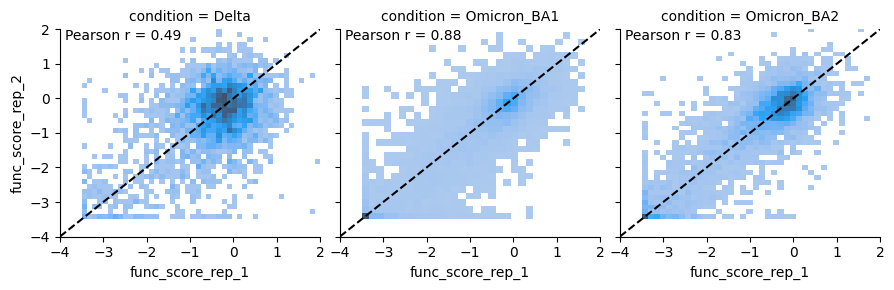

In [5]:
tmp = func_scores_df_processed_collapsed_df.pivot(index=["aa_substitutions", "condition"], columns="replicate", values="func_score").reset_index()
tmp.rename(columns={1: "func_score_rep_1", 2: "func_score_rep_2"}, inplace=True)
tmp.dropna(inplace=True)
g = sns.displot(data=tmp, col="condition", x="func_score_rep_1", y="func_score_rep_2", height=3, 
                kind="hist", common_norm=False, common_bins=False)
for d, ax in zip(g.col_names, g.axes.flat):
    ax.plot([-4, 2], [-4, 2], "k--")
    ax.set_xlim(-4, 2)
    ax.set_ylim(-4, 2)
    ax.annotate(f"Pearson r = {scipy.stats.pearsonr(tmp.query('condition == @d').func_score_rep_1, tmp.query('condition == @d').func_score_rep_2).statistic:.2f}", (0.02, 0.95), xycoords="axes fraction")

### Count aggregation

Alternatively, aggregate unfiltered counts, then compute a single functional score for each variant

In [6]:
func_scores_df = pd.read_csv(
    "input/spike_func_scores_unfiltered_counts.csv").fillna("").drop(columns="func_score")#.query("replicate == 1")

func_scores_df

,pre_count,post_count,aa_substitutions,condition,replicate,n_subs
0,235,331,N87T L517F T1006A,Delta,1,3
1,234,682,D80L,Delta,1,1
2,234,145,A1026V D1168Y,Delta,1,2
3,234,546,G75W K1154E,Delta,1,2
4,234,103,T307S S803L A893V,Delta,1,3
...,...,...,...,...,...,...
770281,287,187,P82S S112T D138T K1038N,Omicron_BA2,2,4
770282,287,170,L179P A222T G261H N405D,Omicron_BA2,2,4
770283,287,58,S27F G413E,Omicron_BA2,2,2
770284,287,488,A222V S1242I,Omicron_BA2,2,2


In [7]:
groups = func_scores_df.groupby(["aa_substitutions", "condition", "replicate"])

func_scores_collapsed_df = groups.agg(
    dict(pre_count="sum", post_count="sum", aa_substitutions="first", condition="first", replicate="first", n_subs="first")
).assign(barcodes=groups.size()).reset_index(drop=True)

pseudocount = 0
func_scores_collapsed_df["func_score"] = np.log2(func_scores_collapsed_df.post_count + pseudocount) - np.log2(func_scores_collapsed_df.pre_count + pseudocount)

# normalize to WT for each condition
groups = func_scores_collapsed_df.groupby(["condition", "replicate"])
for (condition, replicate), group in groups:
    wt = group.query("aa_substitutions == ''").func_score.squeeze()
    func_scores_collapsed_df.loc[group.index, "func_score"] -= wt

func_scores_collapsed_df

/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,pre_count,post_count,aa_substitutions,condition,replicate,n_subs,barcodes,func_score
0,5027212,4967837,,Delta,1,0,10176,0.000000
1,5955236,3000775,,Delta,2,0,8516,0.000000
2,13479201,16707349,,Omicron_BA1,1,0,24216,0.000000
3,15250884,19953602,,Omicron_BA1,2,0,22495,0.000000
4,15195250,12396402,,Omicron_BA2,1,0,21020,0.000000
...,...,...,...,...,...,...,...,...
335519,499,71,Y91V S98Y D138* Y144V N280D N405P P463S S982R ...,Omicron_BA2,2,9,2,-3.160077
335520,166,0,Y91V T108A G261H,Omicron_BA1,2,3,1,-inf
335521,888,71,Y91V T883I,Omicron_BA2,2,2,2,-3.991597
335522,303,0,Y91V V401L K679A D1163G,Omicron_BA1,2,4,1,-inf


Filter the aggregated counts

In [8]:
func_scores_collapsed_df.query("(pre_count >= 100) & (post_count > 0)", inplace=True)
func_scores_collapsed_df.shape

(295757, 8)

In [9]:
func_scores_collapsed_df["func_score"] = func_scores_collapsed_df.func_score.clip(-3.5, 2.5)

In [10]:
func_scores_collapsed_df

,pre_count,post_count,aa_substitutions,condition,replicate,n_subs,barcodes,func_score
0,5027212,4967837,,Delta,1,0,10176,0.000000
1,5955236,3000775,,Delta,2,0,8516,0.000000
2,13479201,16707349,,Omicron_BA1,1,0,24216,0.000000
3,15250884,19953602,,Omicron_BA1,2,0,22495,0.000000
4,15195250,12396402,,Omicron_BA2,1,0,21020,0.000000
...,...,...,...,...,...,...,...,...
335513,633,8,Y91V E132Q Q675L A845E G1167D,Omicron_BA1,2,5,1,-3.500000
335514,497,7,Y91V H505N I1216T,Omicron_BA1,2,3,1,-3.500000
335517,310,26,Y91V S112N M177K L335P N405A C671R K679R T859A...,Omicron_BA2,2,9,2,-3.500000
335519,499,71,Y91V S98Y D138* Y144V N280D N405P P463S S982R ...,Omicron_BA2,2,9,2,-3.160077


Replicate correlations

/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

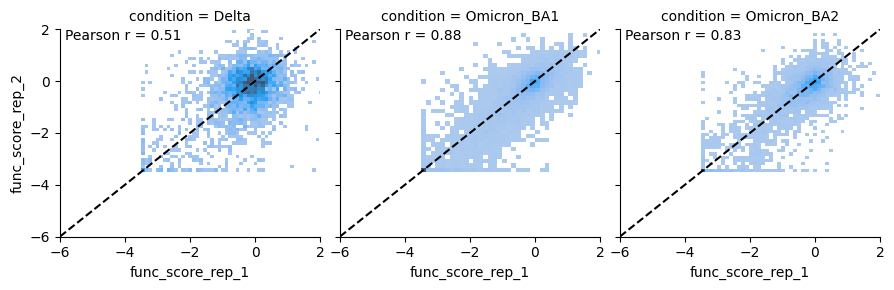

In [11]:
tmp = func_scores_collapsed_df.pivot(index=["aa_substitutions", "condition"], columns="replicate", values="func_score").reset_index()
tmp.rename(columns={1: "func_score_rep_1", 2: "func_score_rep_2"}, inplace=True)
tmp.dropna(inplace=True)
g = sns.displot(data=tmp, col="condition", x="func_score_rep_1", y="func_score_rep_2", height=3, 
                kind="hist", common_norm=False, common_bins=False)
for d, ax in zip(g.col_names, g.axes.flat):
    ax.plot([-6, 2], [-6, 2], "k--")
    ax.set_xlim(-6, 2)
    ax.set_ylim(-6, 2)
    ax.annotate(f"Pearson r = {scipy.stats.pearsonr(tmp.query('condition == @d').func_score_rep_1, tmp.query('condition == @d').func_score_rep_2).statistic:.2f}", (0.02, 0.95), xycoords="axes fraction")

Distribution of number of barcodes

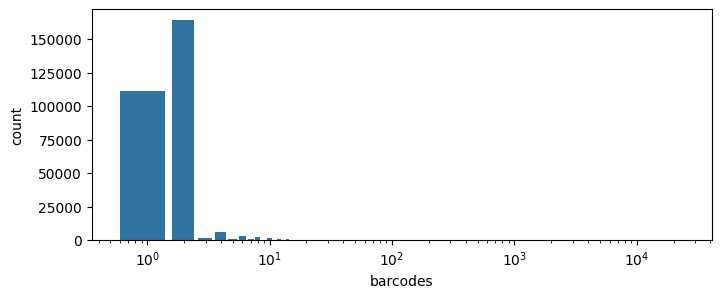

In [12]:
plt.figure(figsize=(8, 3))
sns.countplot(x=func_scores_collapsed_df.barcodes, native_scale=True)
plt.xscale("log")
# plt.yscale("log")
plt.show()

Distribution of number of mutations

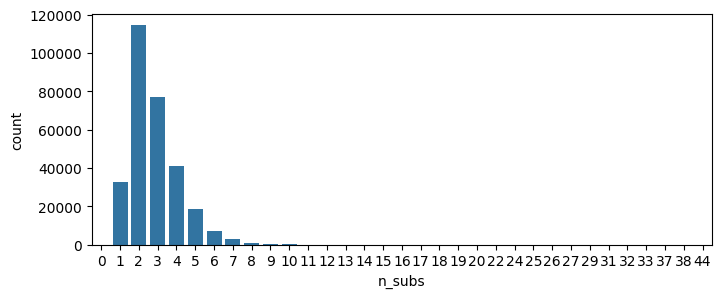

In [13]:
plt.figure(figsize=(8, 3))
sns.countplot(x=func_scores_collapsed_df.n_subs)
plt.show()

Number of variants in each condition

<Axes: xlabel='condition', ylabel='count'>

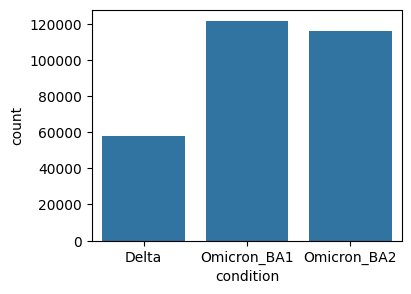

In [14]:
plt.figure(figsize=(4, 3))
sns.countplot(data=func_scores_collapsed_df, x="condition")

Add a weight, which can be used in fitting

In [15]:
func_scores_collapsed_df["weight"] = 1.0 #np.sqrt(func_scores_collapsed_df.barcodes)
func_scores_collapsed_df.head(10)

,pre_count,post_count,aa_substitutions,condition,replicate,n_subs,barcodes,func_score,weight
0,5027212,4967837,,Delta,1,0,10176,0.000000,1.0
1,5955236,3000775,,Delta,2,0,8516,0.000000,1.0
2,13479201,16707349,,Omicron_BA1,1,0,24216,0.000000,1.0
3,15250884,19953602,,Omicron_BA1,2,0,22495,0.000000,1.0
4,15195250,12396402,,Omicron_BA2,1,0,21020,0.000000,1.0
5,18959708,24113895,,Omicron_BA2,2,0,19832,0.000000,1.0
6,978,291,A1015D,Delta,1,1,2,-1.731675,1.0
7,853,156,A1015D,Delta,2,1,2,-1.462176,1.0
9,644,24,A1015D,Omicron_BA2,1,1,2,-3.500000,1.0
10,796,268,A1015D E1188Q,Delta,1,2,2,-1.553395,1.0


Let's use replicate 1 only

In [16]:
func_scores_collapsed_df.query("replicate == 2", inplace=True)
func_scores_collapsed_df

,pre_count,post_count,aa_substitutions,condition,replicate,n_subs,barcodes,func_score,weight
1,5955236,3000775,,Delta,2,0,8516,0.000000,1.0
3,15250884,19953602,,Omicron_BA1,2,0,22495,0.000000,1.0
5,18959708,24113895,,Omicron_BA2,2,0,19832,0.000000,1.0
7,853,156,A1015D,Delta,2,1,2,-1.462176,1.0
14,3757,2030,A1015S,Delta,2,1,6,0.100722,1.0
...,...,...,...,...,...,...,...,...,...
335513,633,8,Y91V E132Q Q675L A845E G1167D,Omicron_BA1,2,5,1,-3.500000,1.0
335514,497,7,Y91V H505N I1216T,Omicron_BA1,2,3,1,-3.500000,1.0
335517,310,26,Y91V S112N M177K L335P N405A C671R K679R T859A...,Omicron_BA2,2,9,2,-3.500000,1.0
335519,499,71,Y91V S98Y D138* Y144V N280D N405P P463S S982R ...,Omicron_BA2,2,9,2,-3.160077,1.0


Define the multidms data object

In [17]:
data = multidms.Data(
        # func_scores_df,
        func_scores_collapsed_df,
        # collapse_identical_variants="mean",
        alphabet=multidms.AAS_WITHSTOP_WITHGAP,
        reference="Omicron_BA1",
        # reference="Omicron_BA2",
        # reference="Delta",
        assert_site_integrity=False,
        verbose=False,
        name=f"rep-1" 
    )
data

/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and J

Data(rep-1)

In [18]:
data.training_data

{'X': {'Delta': BCOO(int8[26743, 10722], nse=869823),
  'Omicron_BA1': BCOO(int8[53209, 10722], nse=137253),
  'Omicron_BA2': BCOO(int8[51122, 10722], nse=853243)},
 'y': {'Delta': Array([ 0.        , -1.46217618,  0.10072214, ..., -0.95950872,
         -3.0166309 , -3.39281081], dtype=float64),
  'Omicron_BA1': Array([ 0.        , -0.1441993 ,  0.15470144, ..., -3.5       ,
         -3.5       , -3.5       ], dtype=float64),
  'Omicron_BA2': Array([ 0.        , -0.04110356, -0.62651354, ..., -3.3366282 ,
         -3.5       , -3.5       ], dtype=float64)},
 'w': {'Delta': Array([1., 1., 1., ..., 1., 1., 1.], dtype=float64),
  'Omicron_BA1': Array([1., 1., 1., ..., 1., 1., 1.], dtype=float64),
  'Omicron_BA2': Array([1., 1., 1., ..., 1., 1., 1.], dtype=float64)}}

Plot the distribution of row-sums of $X$, and the distribution of $y$

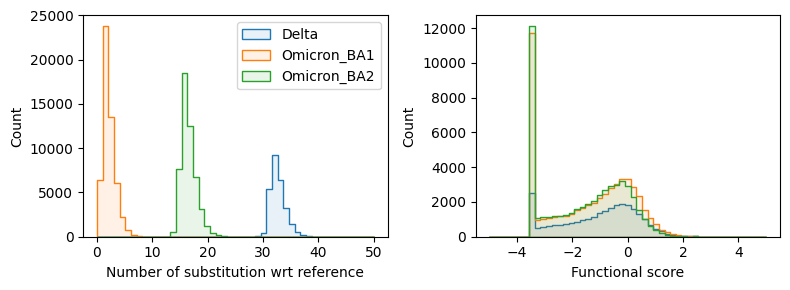

In [19]:
plt.figure(figsize=(8, 3))
for d in data.conditions:
    Xd = data.training_data["X"][d]
    yd = data.training_data["y"][d]
    plt.subplot(121)
    sns.histplot(Xd.sum(1).todense(), bins=np.linspace(0, 50, 50), label=d, element="step", alpha=0.1)
    plt.legend()
    plt.xlabel("Number of substitution wrt reference")
    plt.subplot(122)
    sns.histplot(x=yd, bins=np.linspace(-5, 5, 50), element="step", alpha=0.1)
    plt.xlabel("Functional score")
plt.tight_layout()
plt.show()

Define reference condition

In [20]:
ref_condition = data.reference
ref_condition_idx = data.conditions.index(ref_condition)
ref_condition, ref_condition_idx

('Omicron_BA1', 1)

## Modeling

Given any 1-hot encoding $X_d\in\{0,1\}^{n_d\times M}, d=1\dots,D$, we pose the regression problem as
$$
y_{d} = g_\theta\left(\beta_{0,d} + \sum_m\beta_{m,d} \ x_{m,d}\right) + \epsilon_{d}.
$$
The shifts of mutation effects between conditions $d$ and $d'$ are
$$
\Delta_{m,d,d'} = \beta_{m,d} - \beta_{m,d'},
$$
and the shifts between WTs are
$$
\alpha_{d,d'} = \beta_{0,d} - \beta_{0,d'}.
$$
We will usually use a 1-hot encoding referenced to the WT sequence from one of the $D$ conditions, so that the mutation effects and shifts are interpreted wrt to that condition.
This introduces parameter scaling problems in the non-reference conditions that confound gradient methods, arising from the set of "bundle" sites that define the divergence from the reference encoding (more on this below).
For now, note that the choice of reference condition for interpreting shifts can be made *a posteriori* by fixing $d'$, recovering the parameterization in the main text.

In [21]:
@jax.jit
def φ_pred_fn(params, data):
    result = {}
    for d in data["X"]:
        β0d = params["β0"][d]
        βd = params["β"][d]
        Xd = data["X"][d]
        result[d] = β0d + Xd @ βd
    return result

Functional score prediction

In [22]:
@jax.jit
def y_pred_fn(params, data):
    φ_pred = φ_pred_fn(params, data)
    return φ_pred
    # result = {}
    # for d in data["X"]:
    #     γd = params["γ"][d]
    #     yscale = params["yscale"]
    #     φ0 = params["φ0"]
    #     result[d] = γd + yscale * (jax.scipy.special.expit((φ_pred[d] - φ0) / yscale) - jax.scipy.special.expit(-φ0 / yscale))
    # return result

Smooth piece of the objective function

In [23]:
@jax.jit
def smooth_objective(params, data, condition_weights, l2reg=0.0, huber_delta=1.0):
    result = 0.0
    n = 0
    for d, yd_pred in y_pred_fn(params, data).items():
        yd = data["y"][d]
        βd = params["β"][d]
        wd = condition_weights[d] * data["w"][d]
        result += (wd * jaxopt.loss.huber_loss(yd, yd_pred, delta=huber_delta)).sum()
        result += l2reg * (βd**2).sum()
        n += yd.shape[0]
    return result / n

### Data scale adjustments

To appropriately scale regression parameters, we need condition-specific 1-hot encodings, each wrt the WT in that condition. We get this by bit flipping the "bundle" sites in all conditions.
Now each condition has data referenced to its own WT.

In [24]:
def rereference(X, cols):
    """Flip bits on columns (bool idxs)"""
    if cols.sum():
        X_scipy = scipy.sparse.csr_array((X.data, (X.indices[:, 0], X.indices[:, 1])), shape=X.shape).tolil()
        tmp = X_scipy[: , cols].copy()
        X_scipy[: , cols] = 1
        X_scipy[: , cols] -= tmp
        X_scaled = jax.experimental.sparse.BCOO.from_scipy_sparse(X_scipy)
        X_scaled = jax.experimental.sparse.BCOO((X_scaled.data.astype(jnp.int8), X_scaled.indices), shape=X.shape)

        assert (X[:, cols].sum(0).todense() + X_scaled[:, cols].sum(0).todense() == X.shape[0]).all()

    else:
        X_scaled = X

    return X_scaled


scaled_data = {"X": {}, "y": data.training_data["y"], "w": data.training_data["w"]}

bundle_idxs = {}
bundle_signs = {}

for d in data.training_data["X"]:
    print(d)
    bundle_idxs[d] = data.training_data["X"][d].sum(0).todense() / data.training_data["X"][d].shape[0] > 0.5
    bundle_signs[d] = jnp.where(bundle_idxs[d], -1, 1)

    scaled_data["X"][d] = rereference(data.training_data["X"][d], bundle_idxs[d])

scaled_data

Delta


Omicron_BA1
Omicron_BA2


{'X': {'Delta': BCOO(int8[26743, 10722], nse=78045),
  'Omicron_BA1': BCOO(int8[53209, 10722], nse=137253),
  'Omicron_BA2': BCOO(int8[51122, 10722], nse=158121)},
 'y': {'Delta': Array([ 0.        , -1.46217618,  0.10072214, ..., -0.95950872,
         -3.0166309 , -3.39281081], dtype=float64),
  'Omicron_BA1': Array([ 0.        , -0.1441993 ,  0.15470144, ..., -3.5       ,
         -3.5       , -3.5       ], dtype=float64),
  'Omicron_BA2': Array([ 0.        , -0.04110356, -0.62651354, ..., -3.3366282 ,
         -3.5       , -3.5       ], dtype=float64)},
 'w': {'Delta': Array([1., 1., 1., ..., 1., 1., 1.], dtype=float64),
  'Omicron_BA1': Array([1., 1., 1., ..., 1., 1., 1.], dtype=float64),
  'Omicron_BA2': Array([1., 1., 1., ..., 1., 1., 1.], dtype=float64)}}

Plot the distribution of row-sums of $X$ in the rescaled data. Much nicer!

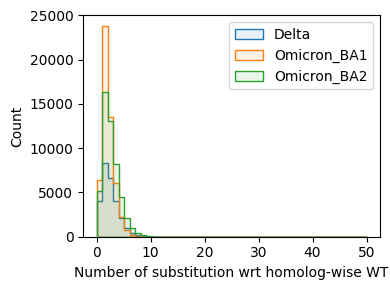

In [25]:
plt.figure(figsize=(4, 3))
for d in data.conditions:
    Xd = scaled_data["X"][d]
    yd = scaled_data["y"][d]
    sns.histplot(Xd.sum(1).todense(), bins=np.linspace(0, 50, 50), label=d, element="step", alpha=0.1)
    plt.legend()
    plt.xlabel("Number of substitution wrt homolog-wise WT")
plt.tight_layout()
plt.show()

## Parameter transformation

Consider just one condition, so that we suppress the index $d$ below for simplicity.
Let $\mathcal{B}$ be the set of indices of the columns of $X$ corresponding to the bundle. We want to work with rescaled data $1-x_m$ at sites $m\in\mathcal{B}$ in the bundle, and $x_m$ at sites $m\notin\mathcal{B}$ not in the bundle. Let $\tilde\beta_0$ and $\tilde\beta_m$ be the intercept and coefficients in the rescaled problem, and $\beta_0$ and $\beta_m$ be the intercept and coefficients in the original data. The equivalence of latent phenotype predictions between scales requires
$$
\tilde\beta_0 + \sum_{m\notin\mathcal{B}}\tilde\beta_m x_m + \sum_{m\in\mathcal{B}}\tilde\beta_m(1 - x_m) = \beta_0 + \sum_m\beta_m x_m.
$$
Matching like terms, we find
$$
\beta_0 = \tilde\beta_0 + \sum_{m\in\mathcal{B}}\tilde\beta_m = \tilde\beta_0 - \sum_{m\in\mathcal{B}}\beta_m,
$$
and
$$
\beta_m =
\begin{cases}
\tilde\beta_m, & m\notin\mathcal{B} \\
-\tilde\beta_m, & m\in\mathcal{B}
\end{cases}.
$$
Note that $\tilde\beta_m^{\mathrm{ref}} = \beta_m^{\mathrm{ref}}$, since $\mathcal{B}^{\mathrm{ref}}=\emptyset$.
Note also that the transform operation is its own inverse.

In [26]:
def transform(params, bundle_idxs):
    params_transformed = {key: val.copy() for key, val in params.items() if key not in ["β", "β0"]}
    params_transformed["β"] = {}
    params_transformed["β0"] = {}
    for d in params["β"]:
        params_transformed["β"][d] = params["β"][d].at[bundle_idxs[d]].mul(-1)
        params_transformed["β0"][d] = params["β0"][d] + params["β"][d][bundle_idxs[d]].sum()
    return params_transformed

## Reference-experiment equivariance during optimization

We currently choose a reference experiment *a priori* and penalize only the differences between each non-reference experiment and the reference experiment.
For this section, consider one mutation, so we suppress the index $m$ below for simplicity.
Our mutation effects across conditions are the vector $β\in\mathbb{R}^D$, and our shift penalty is
$$
\lambda\|\Delta\|_1 = \lambda\|\mathfrak{D} β\|_1,
$$
where, assuming $d=1$ is the reference experiment and $D=3$, we use the difference matrix
$$
\mathfrak{D} = 
\begin{bmatrix}
0 & 0 & 0\\
-1 & 1 & 0\\
-1 & 0 & 1
\end{bmatrix}.
$$
The row of zeros captures the fact that we don't penalize shifts between non-reference experiments.
This lack of symmetry limits the potential sparsity structure of the model.
For example, it's not possible for two non-reference experiments to have the same mutation effect that is different from the reference experiment.
If an epistatic interaction has arisen only on the branch leading to the reference experiment, we can't discover that shift pattern.

It would be more natural to infer a reference-equivariant model that fuses across all conditions symmetrically, after which an *a posteriori* choice of reference experiment can be made for mutation effect interpretation.
We would use the difference matrix
$$
\mathfrak{D} = 
\begin{bmatrix}
0 & -1 & 1\\
-1 & 1 & 0\\
-1 & 0 & 1
\end{bmatrix},
$$
where all shifts are penalized symmetrically.

Finally, we can combine this with the parameter transformation above by specifying $\tilde{\mathfrak{D}}$ such that $\tilde{\mathfrak{D}}\tilde\beta = \mathfrak{D}\beta$.
This is achieved by setting $\tilde{\mathfrak{D}} = \mathfrak{D}(I - 2\mathrm{diag}(B))$, where $B$ is the 1-hot encoding of the bundleness across conditions at this site.
The diagonal matrix $(I - 2\mathrm{diag}(B))$ has -1s for conditions for which the site is in the bundle, and 1s for conditions for which the site is not in the bundle.

### ADMM approach

We next derive the proximal operator for the symmetric fusion problem, using standard augmented Lagrangian methods (see citations below).
This is a special case of the generalized lasso.
Our penalized problem is
$$
\min_{\beta} f(\beta) + \lambda\|\mathfrak{D}\beta\|_1,
$$
where $f$ is the smooth piece of the objective.
To use FISTA, we'll need the gradient $\nabla f$ and the proximal operator $\mathrm{prox}_{\lambda}$, defined as
$$
\mathrm{prox}_{\lambda}(x) = \arg\min_{y}\frac{1}{2}\|x - y\|_2^2 + \lambda\|\mathfrak{D}y\|_1,
$$
which is equivalent to the constrained problem
$$
\mathrm{prox}_{\lambda}(x) = \arg\min_{y, z}\frac{1}{2}\|x - y\|_2^2 + \lambda\|z\|_1 \quad \text{s.t.} \quad \mathfrak{D}y - z = 0.
$$
This can be evaluated by ADMM iterations with dual variable $u$:
$$
\begin{aligned}
y^{(k+1)} &= (I + \rho \mathfrak{D}^\intercal \mathfrak{D})^{-1}(x + \rho \mathfrak{D}^\intercal(z^{(k)} - u^{(k)}))\\
z^{(k+1)} &= S_{\lambda/\rho}(\mathfrak{D}y^{(k+1)} + u^{(k)})\\
u^{(k+1)} &= u^{(k)} + \mathfrak{D}y^{(k+1)} - z^{(k+1)},
\end{aligned}
$$
where $S_{\lambda/\rho}$ is the soft-thresholding operator and $\rho>0$ is the ADMM step-size.
These iterations rapidly converge in terms of the primal and dual residuals:
$$
\begin{aligned}
\text{primal residual} &= \|\mathfrak{D}y^{(k+1)} - z^{(k+1)}\|_2\\
\text{dual residual} &= \rho\|D^\intercal(z^{(k+1)} - z^{(k)})\|_2.
\end{aligned}
$$

To parallelize across all mutations, we simply stack in the column dimensions of $y, z, u$. Thus, we have the proximal operator necessary for the general lasso penalized model.

See:
- [Boyd et al.](https://web.stanford.edu/~boyd/papers/pdf/admm_distr_stats.pdf) for the generalized lasso problem (see $\S6.4.1$).
- [Tibshirani](https://www.stat.cmu.edu/~ryantibs/convexopt-F15/lectures/21-dual-meth.pdf), slide 21
- [Tibshirani and Taylor](https://www.stat.cmu.edu/~ryantibs/papers/genlasso.pdf) for a treatment of the solution path.


<!-- ### Conjecture

We can avoid ADMM and instead use direct soft-thresholding. Introduce auxiliary variable $\bar\beta\in\mathbb{R}$ (loosely interpretable as a condition averaged effect) and use the simple lasso penalty $\lambda\|\beta - \bar\beta 1_D\|$, for which

$$
\mathrm{prox}_{\lambda}(\beta) = \bar\beta 1_D + S_\lambda(\beta_d - \bar\beta 1_D)
$$

This is probably mathematically equivalent to the problem above with the general ADMM hammer. Even if it's somehow not, it is at least morally equivalent. 😃  -->


In [27]:
## uncomment this one to apply the equivariant shift penalty
# D = jnp.array([
#     [1, -1, 0],
#     [0, 1, -1],
#     [-1, 0, 1],
# ], dtype=jnp.float64)

## uncomment this one to apply shift penalties wrt to the reference condition only
D = jnp.eye(3, 3).at[:, ref_condition_idx].set(-1).at[ref_condition_idx].set(0)

D

Array([[ 1., -1.,  0.],
       [ 0.,  0.,  0.],
       [ 0., -1.,  1.]], dtype=float64)

In [28]:
bundle_sign_matrix = jnp.vstack([bundle_signs[d] for d in data.conditions])
# E.g.
bundle_sign_matrix[:, bundle_idxs["Omicron_BA2"]]

Array([[ 1,  1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1, -1],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]],      dtype=int64, weak_type=True)

In [29]:
D_block_diag = scipy.sparse.block_diag([np.array(D) @ np.diag(bundle_sign_matrix[:, col]) for col in range(len(data.mutations))])
Dop = pylops.LinearOperator(Op=scipy.sparse.linalg.aslinearoperator(D_block_diag), dtype=D.dtype, shape=D_block_diag.shape) #pylops.FirstDerivative(shape, edge=True, kind='backward')
eig = np.real((Dop.H * Dop).eigs(neigs=1, which='LM')[0])
eig

3.0000000000000036

Prox on scaled parameters

In [30]:
# @jax.jit
def prox(params, hyperparameters, scaling=1.0):
    # see https://pyproximal.readthedocs.io/en/stable/index.html
    λ, niter, τ, μ = hyperparameters
    assert 0 < μ < τ / eig
    # params["γ"][ref_condition] = 0.0

    # apply prox
    β_ravel = jnp.vstack(params["β"].values()).ravel(order="F")

    β_ravel, Δ_ravel = pyproximal.optimization.primal.LinearizedADMM(
        pyproximal.L2(b=β_ravel), pyproximal.L1(sigma=scaling * λ), Dop,
        niter=niter, tau=τ, mu=μ,
        x0=β_ravel,
        show=False
        )

    β = β_ravel.reshape(-1, len(β_ravel) // 3, order="F")
    Δ = Δ_ravel.reshape(-1, len(Δ_ravel) // 3, order="F")

    # update β dict
    for i, d in enumerate(params["β"]):
        params["β"][d] = β[i]

    # update shifts
    params["Δ"] = Δ

    # clamp β0 for reference condition in non-scaled parameterization (where it's a box constraint)
    params = transform(params, bundle_idxs)
    params["β0"][ref_condition] = 0.0
    params = transform(params, bundle_idxs)

    return params


In [31]:
@jax.jit
def total_objective(params, data, condition_weights, l2reg=0.0, l1reg=0.0, huber_delta=1.0):
    result = smooth_objective(params, data, condition_weights, l2reg=l2reg, huber_delta=huber_delta)
    result += l1reg * jnp.abs(params["Δ"]).sum()
    return result

In [32]:
params0 = dict(
    β={d: jnp.zeros(len(data.mutations)) for d in data.conditions},
    β0={d: jnp.array(0.0) for d in data.conditions},
    # γ={d: jnp.array(0.0) for d in data.conditions},
    # φ0=jnp.array(0.0),
    # yscale=jnp.array(1.0),
    )

params0["Δ"] = jnp.zeros((len(data.conditions), len(data.mutations)))

In [33]:
jax.grad(smooth_objective)(params0, scaled_data, {d: 1.0 for d in scaled_data["X"]})

{'Δ': Array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float64),
 'β': {'Delta': Array([1.47372575e-05, 7.62927812e-05, 3.81463906e-05, ...,
         5.22781722e-05, 1.85914083e-05, 1.57605936e-05], dtype=float64),
  'Omicron_BA1': Array([ 0.00000000e+00,  3.05171125e-05,  0.00000000e+00, ...,
         -2.77650030e-05,  1.38535009e-04,  0.00000000e+00], dtype=float64),
  'Omicron_BA2': Array([0.00000000e+00, 6.10342249e-05, 0.00000000e+00, ...,
         2.96050491e-04, 1.45183224e-04, 0.00000000e+00], dtype=float64)},
 'β0': {'Delta': Array(0.0956391, dtype=float64, weak_type=True),
  'Omicron_BA1': Array(0.22288956, dtype=float64, weak_type=True),
  'Omicron_BA2': Array(0.25063313, dtype=float64, weak_type=True)}}

In [34]:
prox(params0, (1e-6, 100, 1.0, .99 / eig), scaling=1.0)

{'Δ': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'β': {'Delta': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
  'Omicron_BA1': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
  'Omicron_BA2': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64)},
 'β0': {'Delta': Array(0., dtype=float64),
  'Omicron_BA1': Array(0., dtype=float64),
  'Omicron_BA2': Array(0., dtype=float64)}}

In [35]:
total_objective(params0, scaled_data, {d: 1.0 for d in scaled_data["X"]})

Array(1.17131091, dtype=float64)

In [36]:
solver = jaxopt.ProximalGradient(
    smooth_objective,
    prox,
    tol=1e-8,
    maxiter=1000,
    # acceleration=False,
    # stepsize=1e-1,
    maxls=30,
    # decrease_factor=0.8,
    jit=False,
    # verbose=True,
)

In [37]:
l1reg = 0.0
admm_niter = 50
admm_τ = 1.0
admm_μ = 0.99 * admm_τ / eig
hyperparameters_prox = l1reg, admm_niter, admm_τ, admm_μ
l2reg = 1e-3
condition_weights = {"Omicron_BA1": 1.0, "Omicron_BA2": 1.0, "Delta": 1.0}
huber_delta = 1.0

In [38]:
iter = []
stepsize = []
obj = []
error = []
sparsity = []
duality_gap = []

params = params0

state = solver.init_state(
    params,
    hyperparameters_prox,
    l2reg=l2reg,
    condition_weights=condition_weights,
    data=scaled_data,
    huber_delta=huber_delta,
    )

# update = jax.jit(solver.update)
update = solver.update


In [39]:

for _ in range(20000):
    params, state = update(
        params, state,
        hyperparameters_prox,
        l2reg=l2reg,
        condition_weights=condition_weights,
        data=scaled_data,
        huber_delta=huber_delta
        )
    iter.append(int(state.iter_num))
    stepsize.append(float(state.stepsize))
    obj.append(float(total_objective(params, scaled_data, condition_weights, l2reg=l2reg, l1reg=l1reg, huber_delta=huber_delta)))
    error.append(float(state.error))
    # params_unscaled = transform(params, bundle_idxs)
    sparsity.append((params["Δ"] == 0).mean(1))
    β_ravel = jnp.vstack(params["β"].values()).ravel(order="F")
    Δ_ravel = params["Δ"].ravel(order="F")
    duality_gap.append(jnp.sqrt(((Δ_ravel - D_block_diag @ β_ravel))**2).reshape(-1, len(β_ravel) // 3, order="F").sum(0).mean())
    if state.iter_num % 10 == 0:
        with np.printoptions(precision=2, floatmode="fixed"):
            print(f"Iteration {iter[-1]}, objective={obj[-1]:.2e}, stepsize={stepsize[-1]:.2e}, error={error[-1]:.2e}, shift sparsity = {sparsity[-1]}, duality gap = {duality_gap[-1]:.2e}")
    if state.error < 1e-4:
        break

Iteration 10, objective=9.26e-01, stepsize=1.60e+01, error=3.71e-02, shift sparsity = [0.00 1.00 0.00], duality gap = 0.00e+00
Iteration 20, objective=8.66e-01, stepsize=1.60e+01, error=5.42e-02, shift sparsity = [0.00 1.00 0.00], duality gap = 0.00e+00
Iteration 30, objective=8.01e-01, stepsize=1.60e+01, error=6.37e-02, shift sparsity = [0.00 1.00 0.00], duality gap = 0.00e+00
Iteration 40, objective=7.37e-01, stepsize=1.60e+01, error=7.16e-02, shift sparsity = [0.00 1.00 0.00], duality gap = 0.00e+00
Iteration 50, objective=6.77e-01, stepsize=3.20e+01, error=3.96e-02, shift sparsity = [0.00 1.00 0.00], duality gap = 0.00e+00
Iteration 60, objective=6.19e-01, stepsize=1.60e+01, error=8.14e-02, shift sparsity = [0.00 1.00 0.00], duality gap = 0.00e+00
Iteration 70, objective=5.70e-01, stepsize=8.00e+00, error=1.56e-01, shift sparsity = [0.00 1.00 0.00], duality gap = 0.00e+00
Iteration 80, objective=5.33e-01, stepsize=1.60e+01, error=7.07e-02, shift sparsity = [0.00 1.00 0.00], duality

In [45]:
state

ProxGradState(iter_num=Array(16174, dtype=int64, weak_type=True), stepsize=Array(32., dtype=float64), error=Array(9.92000471e-05, dtype=float64), aux=None, velocity={'Δ': Array([[-0.10964781,  0.24879308, -0.63019938, ..., -0.63343866,
         0.14142437, -0.10414721],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04833097, -0.21128656,  0.27591585, ..., -0.43975802,
        -0.1786797 ,  0.04652405]], dtype=float64), 'β': {'Delta': Array([-0.36658128, -2.5506465 , -2.09876846, ...,  0.285537  ,
        0.24964971, -0.35133814], dtype=float64), 'Omicron_BA1': Array([-0.25693347, -2.79943958, -1.46856908, ...,  0.91897566,
        0.10822534, -0.24719093], dtype=float64), 'Omicron_BA2': Array([-0.2086025 , -3.01072614, -1.19265324, ...,  0.47921764,
       -0.07045436, -0.20066688], dtype=float64)}, 'β0': {'Delta': Array(-0.17063019, dtype=float64), 'Omicron_BA1': Array(0., dtype=float64), 'Omicron_BA2': Array(-0.32105412

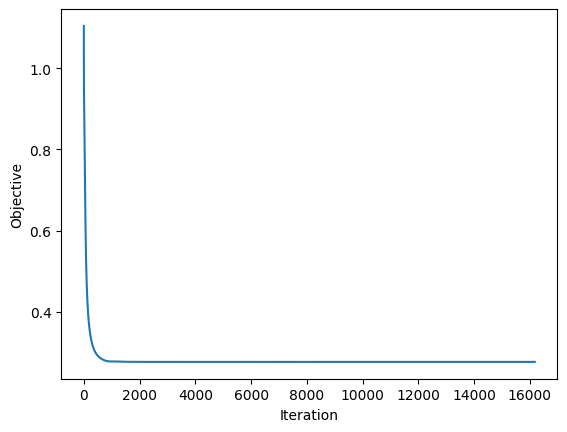

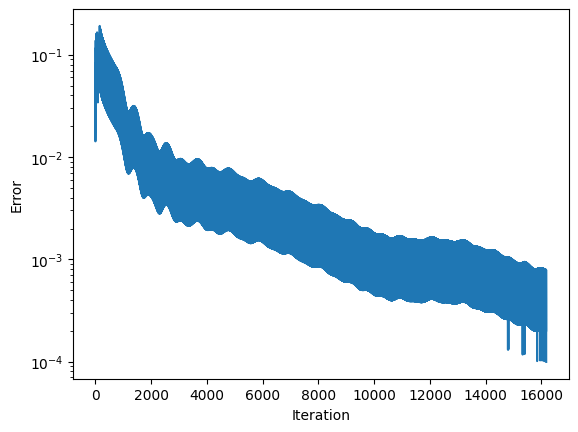

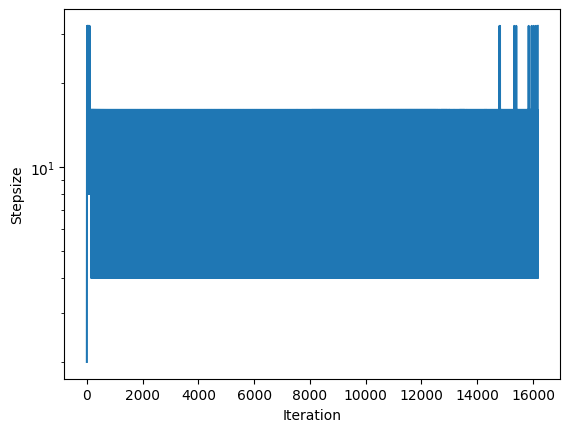

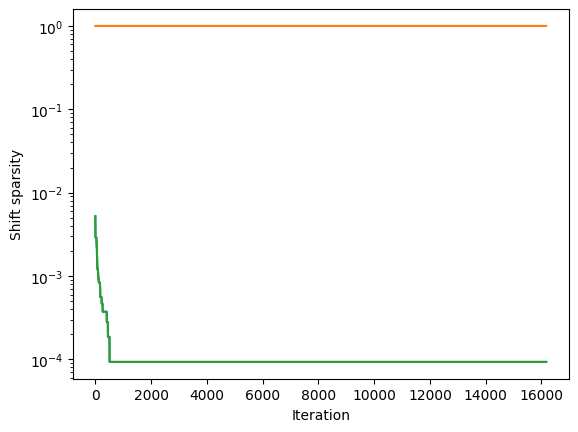

In [46]:
plt.plot(obj)
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.show()

plt.plot(error)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.yscale("log")
plt.show()

plt.plot(stepsize)
plt.xlabel("Iteration")
plt.ylabel("Stepsize")
plt.yscale("log")
plt.show()

plt.plot(sparsity)
plt.xlabel("Iteration")
plt.ylabel("Shift sparsity")
plt.yscale("log")
plt.show()

if any(duality_gap):
    plt.plot(duality_gap)
    plt.xlabel("Iteration")
    plt.ylabel("Duality gap")
    plt.yscale("log")
    plt.show()

In [42]:
for leaf1, leaf2 in zip(jax.tree_util.tree_leaves(transform(transform(params, bundle_idxs), bundle_idxs)), jax.tree_util.tree_leaves(params)):
    assert (leaf1 == leaf2).all(), f"{leaf1=} {leaf2=}"

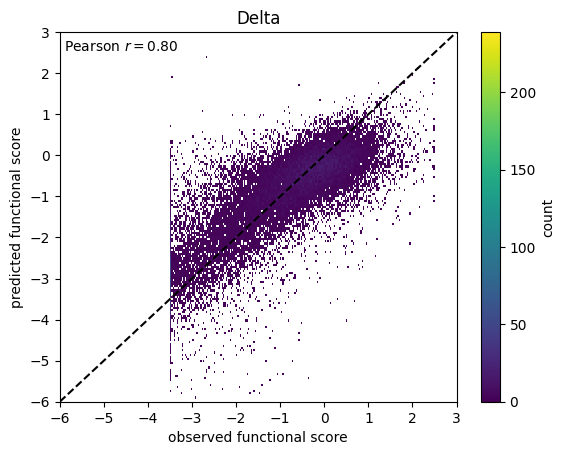

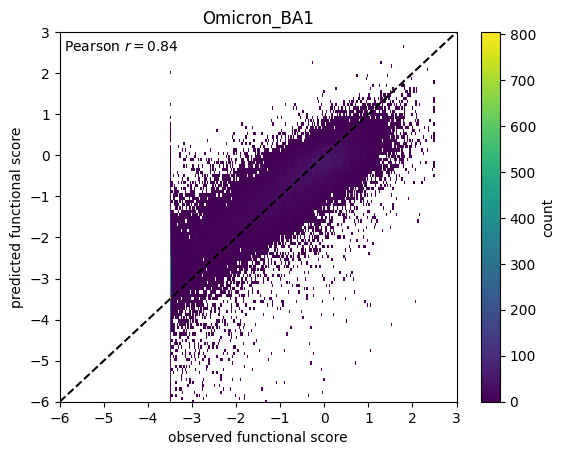

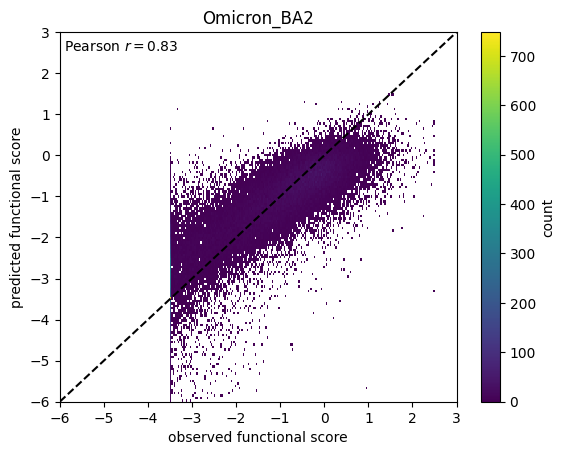

In [43]:
y_pred = y_pred_fn(params, scaled_data)
for d in data.conditions:
    # plt.scatter(scaled_data["y"][d], y_pred[d], s=2, alpha=0.2, color="black")
    sns.histplot(x=scaled_data["y"][d], y=y_pred[d], bins=200, cmap="viridis", cbar=True, cbar_kws={"label": "count"})
    plt.annotate(f"Pearson $r={scipy.stats.pearsonr(scaled_data['y'][d], y_pred[d]).statistic:.2f}$",
                    xy=(0.01, 0.95), xycoords="axes fraction")
    plt.plot([-6, 3], [-6, 3], "k--")
    plt.xlim(-6, 3)
    plt.ylim(-6, 3)
    plt.xlabel("observed functional score")
    plt.ylabel("predicted functional score")
    plt.title(d)
    plt.show()

In [44]:
params

{'Δ': array([[-0.10964385,  0.24878039, -0.63015634, ..., -0.63343957,
          0.14142168, -0.10414248],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.04833197, -0.21129491,  0.27592066, ..., -0.43975897,
         -0.17867868,  0.04652497]]),
 'β': {'Delta': Array([-0.3665856 , -2.55064954, -2.09877187, ...,  0.2855373 ,
          0.24964739, -0.35134135], dtype=float64),
  'Omicron_BA1': Array([-0.25694175, -2.79942993, -1.46861553, ...,  0.91897687,
          0.10822572, -0.24719887], dtype=float64),
  'Omicron_BA2': Array([-0.20860978, -3.01072484, -1.19269487, ...,  0.4792179 ,
         -0.07045296, -0.20067389], dtype=float64)},
 'β0': {'Delta': Array(-0.17062913, dtype=float64),
  'Omicron_BA1': Array(0., dtype=float64),
  'Omicron_BA2': Array(-0.32102417, dtype=float64)}}

### To do

- Plot the loss surface wrt $\beta_i, \beta_j$ for $i\in\mathcal{B}, j\notin\mathcal{B}$, compared to the loss surface wrt $\tilde\beta_i, \tilde\beta_j$. This should clearly demonstrate the scaling problem and its resolution.